Normal Patients

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7680, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 7680, 1)     0           ['input_1[0][0]']                
                                                                                                  
 separable_conv1d (SeparableCon  (None, 7680, 64)    143         ['gaussian_noise[0][0]']         
 v1D)                                                                                             
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 3840, 64)     0           ['separable_conv1d[0][0]']   

1311/1311 [==============================] - 101s 77ms/step - loss: 0.0213 - accuracy: 0.8392 - val_loss: 0.0307 - val_accuracy: 0.8095 - lr: 1.5625e-06
Epoch 60/100
1311/1311 [==============================] - 101s 77ms/step - loss: 0.0213 - accuracy: 0.8385 - val_loss: 0.0305 - val_accuracy: 0.8091 - lr: 1.5625e-06
Epoch 61/100
1311/1311 [==============================] - 100s 76ms/step - loss: 0.0213 - accuracy: 0.8389 - val_loss: 0.0306 - val_accuracy: 0.8090 - lr: 1.5625e-06
Epoch 62/100
1311/1311 [==============================] - 101s 77ms/step - loss: 0.0213 - accuracy: 0.8399 - val_loss: 0.0306 - val_accuracy: 0.8095 - lr: 7.8125e-07
Epoch 63/100
1311/1311 [==============================] - 100s 76ms/step - loss: 0.0212 - accuracy: 0.8394 - val_loss: 0.0306 - val_accuracy: 0.8093 - lr: 7.8125e-07
Epoch 64/100
1311/1311 [==============================] - 100s 76ms/step - loss: 0.0212 - accuracy: 0.8388 - val_loss: 0.0306 - val_accuracy: 0.8103 - lr: 7.8125e-07
Epoch 65/100
1311

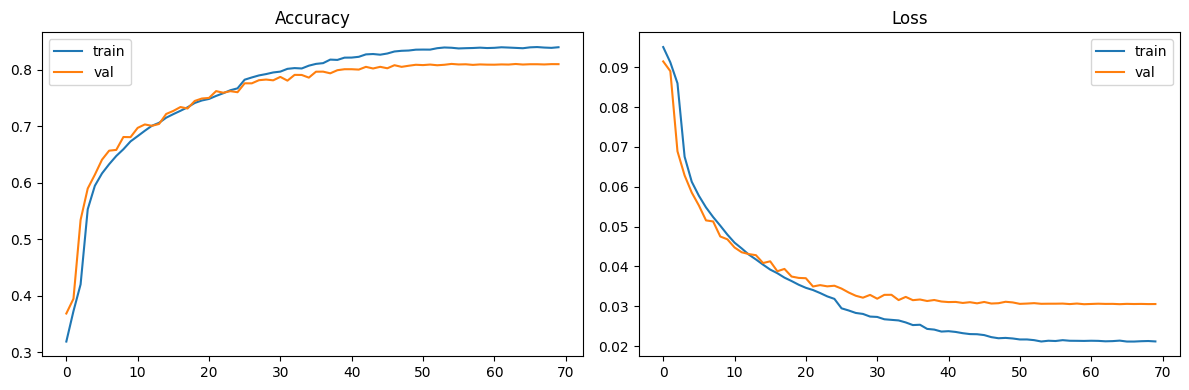

656/656 [==============================] - 7s 10ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.67      0.72      4193
           1       0.96      0.90      0.93      4193
           2       0.67      0.69      0.68      4193
           3       0.92      0.95      0.93      4193
           4       0.74      0.83      0.78      4193

    accuracy                           0.81     20965
   macro avg       0.81      0.81      0.81     20965
weighted avg       0.81      0.81      0.81     20965



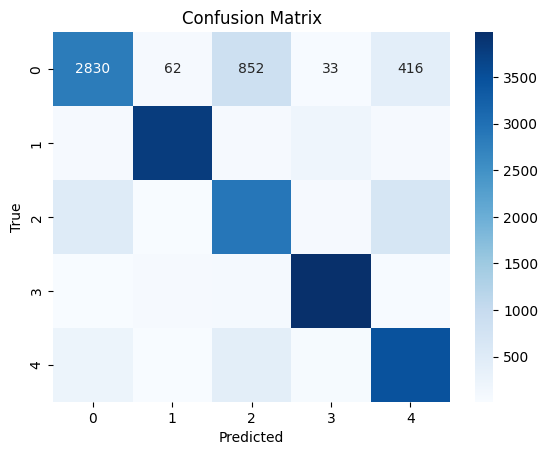


🧠 Cohen Kappa Score: 0.7614


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp83hhq_48\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp83hhq_48\assets



⏱️ Total training time: 119.80 minutes


In [5]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

tf.keras.backend.clear_session()

# ✅ Ensure GPU Usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# ⏱️ Start Timing
start_time = time.time()

# 📂 Load PPG Data
folder_path = r"C:\Users\DST\Desktop\micro_AK\normal"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_list, y_list = [], []
for file in mat_files:
    mat = scipy.io.loadmat(file)
    X_list.append(mat['ppg_signals'])
    y_list.append(mat['sleep_stages'].flatten())

X = np.vstack(X_list)
y = np.concatenate(y_list)

# ✅ Data Augmentation Functions
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

# 🔁 Class-wise Augmentation (focus on underrepresented)
np.random.seed(42)
augmented = []
target_distribution = np.bincount(y)
minority_classes = np.where(target_distribution < np.median(target_distribution))[0]

for signal, label in zip(X, y):
    if label in minority_classes:
        if np.random.rand() < 0.5:
            signal = jitter(signal)
        if np.random.rand() < 0.5:
            signal = magnitude_warp(signal)
        if np.random.rand() < 0.5:
            signal = scaling(signal.reshape(1, -1)).flatten()
    augmented.append(signal)

X = np.array(augmented)

# 🔄 Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 🧩 Handle Class Imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 🧠 Class Weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 🔁 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# 🔷 Preprocessing
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=5)

# ⚠️ Focal Loss Function
def focal_loss(gamma=1.5, alpha=0.5):
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss_fn

# 🚀 Hybrid CNN-RVFL Model with Attention
def build_hybrid_cnn_rvfl(input_shape):
    inputs = Input(shape=input_shape)
    x = GaussianNoise(0.05)(inputs)

    x = SeparableConv1D(64, 15, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same')(x)

    x = SeparableConv1D(64, 7, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same')(res)
    res = MaxPooling1D(2)(res)

    x = SeparableConv1D(128, 5, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(128, 1, padding='same')(res)
    res = MaxPooling1D(2)(res)

    # Attention Mechanism (FIXED)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(256, activation="relu")(attn)
    attn = Dense(128, activation="sigmoid")(attn)  # Match channel size with x
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])

    x = Add()([x, res])
    x = LayerNormalization()(x)

    # RVFL Part
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# ⚙️ Compile & Train
model = build_hybrid_cnn_rvfl((X_train.shape[1], 1))
model.compile(optimizer=Adam(1e-4), loss=focal_loss(), metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat),
                    epochs=100, batch_size=64, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

# 📉 Training Curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Evaluation
y_pred = model.predict(X_test)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# 💾 Save for Deployment
model.save("cnn_rvfl_final_model.keras")

# ✅ Export for TFLite (Edge Devices)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_rvfl_model.tflite", "wb") as f:
    f.write(tflite_model)

# ⏱️ Total Training Time
end_time = time.time()
print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")


In [6]:
print(cm)

[[2830   62  852   33  416]
 [  66 3791   73  201   62]
 [ 518   26 2899   71  679]
 [  25   66   83 3983   36]
 [ 243   15  425   50 3460]]


Apnea Patients

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7680, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 7680, 1)     0           ['input_1[0][0]']                
                                                                                                  
 separable_conv1d (SeparableCon  (None, 7680, 64)    143         ['gaussian_noise[0][0]']         
 v1D)                                                                                             
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 3840, 64)     0           ['separable_conv1d[0][0]']   

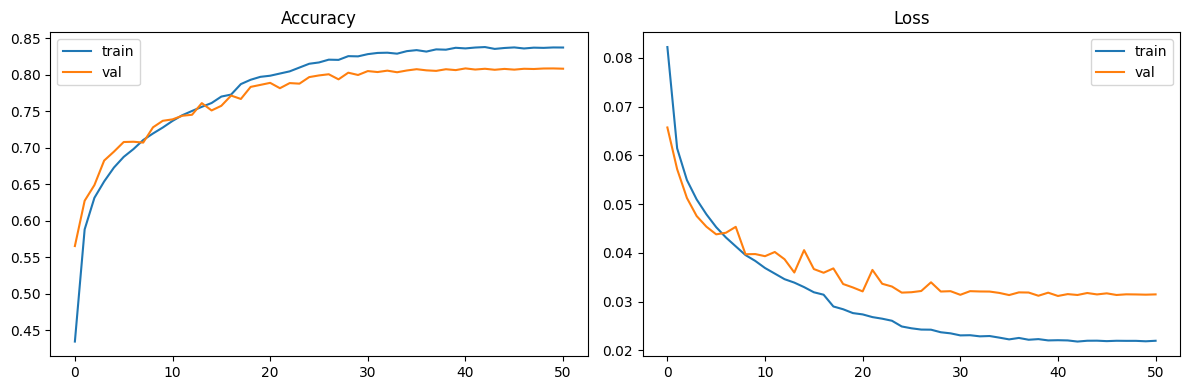

682/682 [==============================] - 7s 10ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74      4363
           1       0.98      0.85      0.91      4362
           2       0.68      0.61      0.64      4362
           3       0.94      0.98      0.96      4363
           4       0.70      0.89      0.79      4362

    accuracy                           0.81     21812
   macro avg       0.82      0.81      0.81     21812
weighted avg       0.82      0.81      0.81     21812

[[3114   41  811   10  387]
 [ 205 3701  124  195  137]
 [ 556   15 2665   41 1085]
 [  33   10   33 4260   27]
 [ 152    3  296    8 3903]]

🧠 Cohen Kappa Score: 0.7611


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpad0yh7do\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpad0yh7do\assets



⏱️ Total training time: 95.67 minutes


In [8]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

tf.keras.backend.clear_session()

# ✅ Ensure GPU Usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# ⏱️ Start Timing
start_time = time.time()

# 📂 Load PPG Data
folder_path = r"D:\abhishek_extracted\apnea"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_list, y_list = [], []
for file in mat_files:
    mat = scipy.io.loadmat(file)
    X_list.append(mat['ppg_signals'])
    y_list.append(mat['sleep_stages'].flatten())

X = np.vstack(X_list)
y = np.concatenate(y_list)

# ✅ Data Augmentation Functions
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

# 🔁 Class-wise Augmentation (focus on underrepresented)
np.random.seed(42)
augmented = []
target_distribution = np.bincount(y)
minority_classes = np.where(target_distribution < np.median(target_distribution))[0]

for signal, label in zip(X, y):
    if label in minority_classes:
        if np.random.rand() < 0.5:
            signal = jitter(signal)
        if np.random.rand() < 0.5:
            signal = magnitude_warp(signal)
        if np.random.rand() < 0.5:
            signal = scaling(signal.reshape(1, -1)).flatten()
    augmented.append(signal)

X = np.array(augmented)

# 🔄 Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 🧩 Handle Class Imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 🧠 Class Weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 🔁 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# 🔷 Preprocessing
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=5)

# ⚠️ Focal Loss Function
def focal_loss(gamma=1.5, alpha=0.5):
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss_fn

# 🚀 Hybrid CNN-RVFL Model with Attention
def build_hybrid_cnn_rvfl(input_shape):
    inputs = Input(shape=input_shape)
    x = GaussianNoise(0.05)(inputs)

    x = SeparableConv1D(64, 15, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same')(x)

    x = SeparableConv1D(64, 7, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same')(res)
    res = MaxPooling1D(2)(res)

    x = SeparableConv1D(128, 5, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(128, 1, padding='same')(res)
    res = MaxPooling1D(2)(res)

    # Attention Mechanism (FIXED)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(256, activation="relu")(attn)
    attn = Dense(128, activation="sigmoid")(attn)  # Match channel size with x
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])

    x = Add()([x, res])
    x = LayerNormalization()(x)

    # RVFL Part
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# ⚙️ Compile & Train
model = build_hybrid_cnn_rvfl((X_train.shape[1], 1))
model.compile(optimizer=Adam(1e-4), loss=focal_loss(), metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat),
                    epochs=100, batch_size=64, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

# 📉 Training Curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Evaluation
y_pred = model.predict(X_test)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# 💾 Save for Deployment
model.save("cnn_rvfl_final_model.keras")

# ✅ Export for TFLite (Edge Devices)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_rvfl_model.tflite", "wb") as f:
    f.write(tflite_model)

# ⏱️ Total Training Time
end_time = time.time()
print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")


Insomnia Patients

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7680, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 7680, 1)     0           ['input_1[0][0]']                
                                                                                                  
 separable_conv1d (SeparableCon  (None, 7680, 64)    143         ['gaussian_noise[0][0]']         
 v1D)                                                                                             
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 3840, 64)     0           ['separable_conv1d[0][0]']   

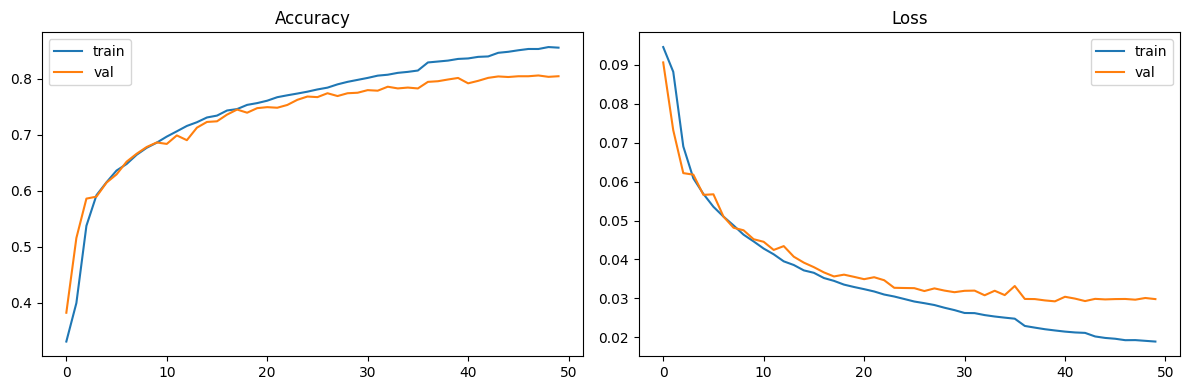

598/598 [==============================] - 6s 9ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67      3827
           1       0.95      0.91      0.93      3827
           2       0.65      0.62      0.64      3827
           3       0.97      0.95      0.96      3828
           4       0.74      0.89      0.81      3827

    accuracy                           0.80     19136
   macro avg       0.80      0.80      0.80     19136
weighted avg       0.80      0.80      0.80     19136

[[2455   61  875   12  424]
 [ 142 3471   73   81   60]
 [ 711   22 2389   27  678]
 [  54   74   39 3630   31]
 [ 130    8  286    4 3399]]

🧠 Cohen Kappa Score: 0.7523


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpsjoknhq8\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpsjoknhq8\assets



⏱️ Total training time: 72.17 minutes


In [9]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

tf.keras.backend.clear_session()

# ✅ Ensure GPU Usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# ⏱️ Start Timing
start_time = time.time()

# 📂 Load PPG Data
folder_path = r"D:\abhishek_extracted\insomnia"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_list, y_list = [], []
for file in mat_files:
    mat = scipy.io.loadmat(file)
    X_list.append(mat['ppg_signals'])
    y_list.append(mat['sleep_stages'].flatten())

X = np.vstack(X_list)
y = np.concatenate(y_list)

# ✅ Data Augmentation Functions
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

# 🔁 Class-wise Augmentation (focus on underrepresented)
np.random.seed(42)
augmented = []
target_distribution = np.bincount(y)
minority_classes = np.where(target_distribution < np.median(target_distribution))[0]

for signal, label in zip(X, y):
    if label in minority_classes:
        if np.random.rand() < 0.5:
            signal = jitter(signal)
        if np.random.rand() < 0.5:
            signal = magnitude_warp(signal)
        if np.random.rand() < 0.5:
            signal = scaling(signal.reshape(1, -1)).flatten()
    augmented.append(signal)

X = np.array(augmented)

# 🔄 Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 🧩 Handle Class Imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 🧠 Class Weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 🔁 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# 🔷 Preprocessing
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=5)

# ⚠️ Focal Loss Function
def focal_loss(gamma=1.5, alpha=0.5):
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss_fn

# 🚀 Hybrid CNN-RVFL Model with Attention
def build_hybrid_cnn_rvfl(input_shape):
    inputs = Input(shape=input_shape)
    x = GaussianNoise(0.05)(inputs)

    x = SeparableConv1D(64, 15, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same')(x)

    x = SeparableConv1D(64, 7, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same')(res)
    res = MaxPooling1D(2)(res)

    x = SeparableConv1D(128, 5, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(128, 1, padding='same')(res)
    res = MaxPooling1D(2)(res)

    # Attention Mechanism (FIXED)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(256, activation="relu")(attn)
    attn = Dense(128, activation="sigmoid")(attn)  # Match channel size with x
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])

    x = Add()([x, res])
    x = LayerNormalization()(x)

    # RVFL Part
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# ⚙️ Compile & Train
model = build_hybrid_cnn_rvfl((X_train.shape[1], 1))
model.compile(optimizer=Adam(1e-4), loss=focal_loss(), metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat),
                    epochs=100, batch_size=64, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

# 📉 Training Curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Evaluation
y_pred = model.predict(X_test)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# 💾 Save for Deployment
model.save("cnn_rvfl_final_model.keras")

# ✅ Export for TFLite (Edge Devices)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_rvfl_model.tflite", "wb") as f:
    f.write(tflite_model)

# ⏱️ Total Training Time
end_time = time.time()
print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")


PLM patients

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7680, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 7680, 1)     0           ['input_1[0][0]']                
                                                                                                  
 separable_conv1d (SeparableCon  (None, 7680, 64)    143         ['gaussian_noise[0][0]']         
 v1D)                                                                                             
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 3840, 64)     0           ['separable_conv1d[0][0]']   

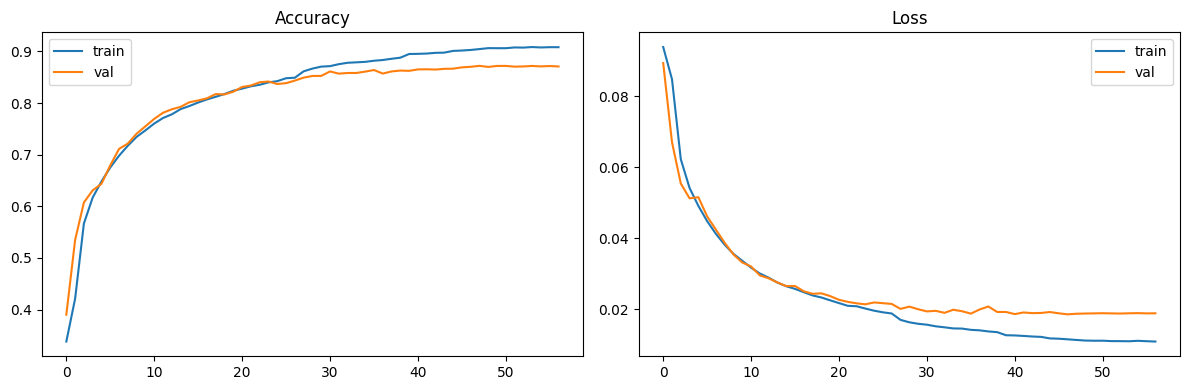

737/737 [==============================] - 9s 10ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74      4712
           1       0.86      0.95      0.90      4711
           2       0.72      0.74      0.73      4711
           3       0.99      0.99      0.99      4712
           4       0.98      0.97      0.98      4711

    accuracy                           0.87     23557
   macro avg       0.87      0.87      0.87     23557
weighted avg       0.87      0.87      0.87     23557

[[3313  293 1075    5   26]
 [  73 4484  153    0    1]
 [ 766  425 3485    9   26]
 [   4    3   18 4663   24]
 [  26   21   81   28 4555]]

🧠 Cohen Kappa Score: 0.8378


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp_jhvcwut\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp_jhvcwut\assets



⏱️ Total training time: 113.89 minutes


In [10]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

tf.keras.backend.clear_session()

# ✅ Ensure GPU Usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# ⏱️ Start Timing
start_time = time.time()

# 📂 Load PPG Data
folder_path = r"D:\abhishek_extracted\plm"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_list, y_list = [], []
for file in mat_files:
    mat = scipy.io.loadmat(file)
    X_list.append(mat['ppg_signals'])
    y_list.append(mat['sleep_stages'].flatten())

X = np.vstack(X_list)
y = np.concatenate(y_list)

# ✅ Data Augmentation Functions
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

# 🔁 Class-wise Augmentation (focus on underrepresented)
np.random.seed(42)
augmented = []
target_distribution = np.bincount(y)
minority_classes = np.where(target_distribution < np.median(target_distribution))[0]

for signal, label in zip(X, y):
    if label in minority_classes:
        if np.random.rand() < 0.5:
            signal = jitter(signal)
        if np.random.rand() < 0.5:
            signal = magnitude_warp(signal)
        if np.random.rand() < 0.5:
            signal = scaling(signal.reshape(1, -1)).flatten()
    augmented.append(signal)

X = np.array(augmented)

# 🔄 Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 🧩 Handle Class Imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 🧠 Class Weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 🔁 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# 🔷 Preprocessing
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=5)

# ⚠️ Focal Loss Function
def focal_loss(gamma=1.5, alpha=0.5):
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss_fn

# 🚀 Hybrid CNN-RVFL Model with Attention
def build_hybrid_cnn_rvfl(input_shape):
    inputs = Input(shape=input_shape)
    x = GaussianNoise(0.05)(inputs)

    x = SeparableConv1D(64, 15, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same')(x)

    x = SeparableConv1D(64, 7, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same')(res)
    res = MaxPooling1D(2)(res)

    x = SeparableConv1D(128, 5, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(128, 1, padding='same')(res)
    res = MaxPooling1D(2)(res)

    # Attention Mechanism (FIXED)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(256, activation="relu")(attn)
    attn = Dense(128, activation="sigmoid")(attn)  # Match channel size with x
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])

    x = Add()([x, res])
    x = LayerNormalization()(x)

    # RVFL Part
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# ⚙️ Compile & Train
model = build_hybrid_cnn_rvfl((X_train.shape[1], 1))
model.compile(optimizer=Adam(1e-4), loss=focal_loss(), metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat),
                    epochs=100, batch_size=64, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

# 📉 Training Curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Evaluation
y_pred = model.predict(X_test)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# 💾 Save for Deployment
model.save("cnn_rvfl_final_model.keras")

# ✅ Export for TFLite (Edge Devices)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_rvfl_model.tflite", "wb") as f:
    f.write(tflite_model)

# ⏱️ Total Training Time
end_time = time.time()
print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")


In [2]:
import spektral
print(spektral.__version__)


1.3.1


EXPERIMENTATION - PLM - 39 - MSRFuseNet - (No preprocessing pipeline - heavy model) - Focal Loss - (slight overfitting)

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7680, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 7680, 1)     0           ['input_1[0][0]']                
                                                                                                  
 separable_conv1d (SeparableCon  (None, 7680, 64)    143         ['gaussian_noise[0][0]']         
 v1D)                                                                                             
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 3840, 64)     0           ['separable_conv1d[0][0]']   

                                                                                                  
 dense_3 (Dense)                (None, 128)          32896       ['dense_2[0][0]']                
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 1920, 64)    0           ['separable_conv1d_7[0][0]']     
                                                                                                  
 lambda_1 (Lambda)              (None, 1, 128)       0           ['dense_3[0][0]']                
                                                                                                  
 separable_conv1d_10 (Separable  (None, 1920, 128)   8384        ['max_pooling1d_2[0][0]']        
 Conv1D)                                                                                          
                                                                                                  
 multiply_

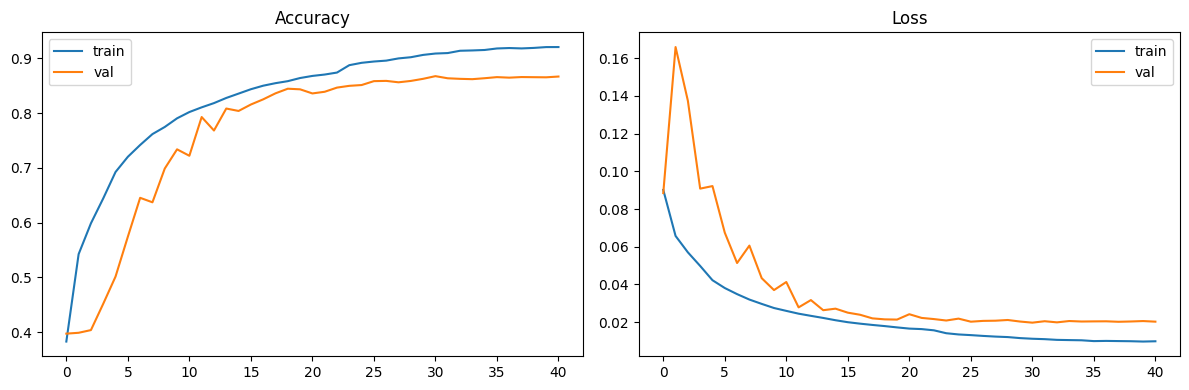

737/737 [==============================] - 22s 29ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      4712
           1       0.88      0.94      0.91      4711
           2       0.70      0.78      0.74      4711
           3       0.99      0.99      0.99      4712
           4       0.99      0.95      0.97      4711

    accuracy                           0.87     23557
   macro avg       0.87      0.87      0.87     23557
weighted avg       0.87      0.87      0.87     23557

[[3240  250 1200    9   13]
 [  88 4405  217    0    1]
 [ 694  310 3677   11   19]
 [   8    1   40 4646   17]
 [  51   24  144   25 4467]]

🧠 Cohen Kappa Score: 0.8343


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp_q71jxo0\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp_q71jxo0\assets



⏱️ Total training time: 200.63 minutes


In [2]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

tf.keras.backend.clear_session()

# ✅ Ensure GPU Usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# ⏱️ Start Timing
start_time = time.time()

# 📂 Load PPG Data
folder_path = r"D:\abhishek_extracted\plm"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_list, y_list = [], []
for file in mat_files:
    mat = scipy.io.loadmat(file)
    X_list.append(mat['ppg_signals'])
    y_list.append(mat['sleep_stages'].flatten())

X = np.vstack(X_list)
y = np.concatenate(y_list)

# ✅ Data Augmentation Functions
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

# 🔁 Class-wise Augmentation (focus on underrepresented)
np.random.seed(42)
augmented = []
target_distribution = np.bincount(y)
minority_classes = np.where(target_distribution < np.median(target_distribution))[0]

for signal, label in zip(X, y):
    if label in minority_classes:
        if np.random.rand() < 0.5:
            signal = jitter(signal)
        if np.random.rand() < 0.5:
            signal = magnitude_warp(signal)
        if np.random.rand() < 0.5:
            signal = scaling(signal.reshape(1, -1)).flatten()
    augmented.append(signal)

X = np.array(augmented)

# 🔄 Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 🧩 Handle Class Imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 🧠 Class Weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 🔁 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# 🔷 Preprocessing
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=5)

# ⚠️ Focal Loss Function
def focal_loss(gamma=1.5, alpha=0.5):
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss_fn

# 🔹 MSR-SE Block: Multi-Scale Residual Squeeze-and-Excite
def MSR_SE_Block(x, filters):
    branch1 = SeparableConv1D(filters, 3, padding='same', activation='relu')(x)
    branch2 = SeparableConv1D(filters, 5, padding='same', activation='relu')(x)
    branch3 = SeparableConv1D(filters, 7, padding='same', activation='relu')(x)

    concat = tf.keras.layers.Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(filters, activation='relu')(squeeze)
    excitation = Dense(concat.shape[-1], activation='sigmoid')(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])

    residual = SeparableConv1D(concat.shape[-1], 1, padding='same')(x)
    out = Add()([scaled, residual])
    return LayerNormalization()(out)

# 🔹 Frequency Fusion Block
def FrequencyFusionBlock(x, filters):
    # Low-frequency emphasis (smooth features)
    low = SeparableConv1D(filters, 7, padding='same', activation='relu')(x)
    # High-frequency: subtract average pooled signal
    high = x - AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    out = Add()([low, high])
    return LayerNormalization()(out)


def build_hybrid_cnn_rvfl(input_shape):
    inputs = Input(shape=input_shape)
    x = GaussianNoise(0.05)(inputs)

    # First CNN Block
    x = SeparableConv1D(64, 15, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)

    # 🔹 Add MSR-SE Block
    x = MSR_SE_Block(x, 64)

    # Second Conv Block + Res
    res = SeparableConv1D(32, 1, padding='same')(x)
    x = SeparableConv1D(64, 7, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same')(res)
    res = MaxPooling1D(2)(res)

    # 🔹 Frequency Fusion Block
    x = FrequencyFusionBlock(x, 64)

    # Third Conv Block
    x = SeparableConv1D(128, 5, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(128, 1, padding='same')(res)
    res = MaxPooling1D(2)(res)

    # Attention
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(256, activation="relu")(attn)
    attn = Dense(128, activation="sigmoid")(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])

    # Residual Merge
    x = Add()([x, res])
    x = LayerNormalization()(x)

    # RVFL-like Dense Layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)

    return Model(inputs, outputs)

# ⚙️ Compile & Train
model = build_hybrid_cnn_rvfl((X_train.shape[1], 1))
model.compile(optimizer=Adam(1e-4), loss=focal_loss(), metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat),
                    epochs=100, batch_size=64, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

# 📉 Training Curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Evaluation
y_pred = model.predict(X_test)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# 💾 Save for Deployment
model.save("cnn_rvfl_final_model.keras")

# ✅ Export for TFLite (Edge Devices)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_rvfl_model.tflite", "wb") as f:
    f.write(tflite_model)

# ⏱️ Total Training Time
end_time = time.time()
print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")


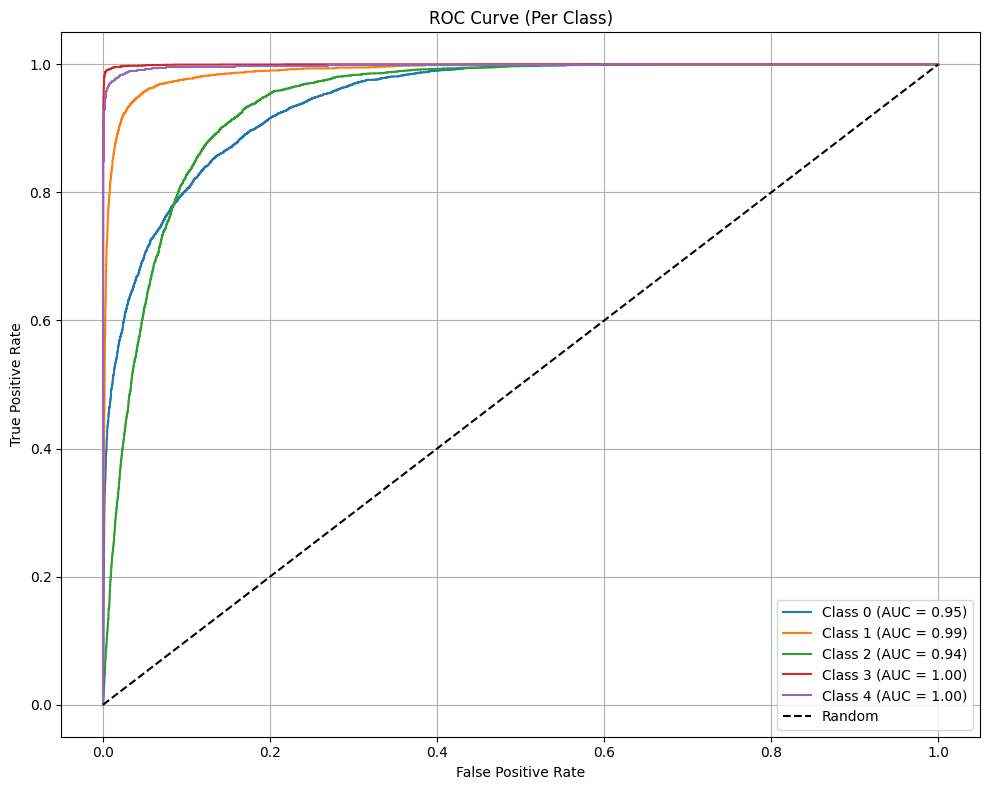

In [3]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 5
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")



📈 Final Accuracy: Train = 0.9207, Val = 0.8668
📉 Final Loss: Train = 0.0099, Val = 0.0203


In [5]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")



✅ Overall Test Accuracy: 0.8675


In [6]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.8675298349651417
Weighted F1 Score: 0.8675294140895367
Macro Precision: 0.8705383723141822
Macro Recall: 0.8674729951466406


HYPERPARAMETER TUNING - PLM - Change in Alpha strategy

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7680, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 7680, 1)     0           ['input_1[0][0]']                
                                                                                                  
 separable_conv1d (SeparableCon  (None, 7680, 64)    143         ['gaussian_noise[0][0]']         
 v1D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 7680, 64)    256         ['separable_conv1d[0][0]']   

 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 1920, 64)    256         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 1920, 64)     0           ['max_pooling1d_1[0][0]',        
                                                                  'average_pooling1d[0][0]']      
                                                                                                  
 add_1 (Add)                    (None, 1920, 64)     0           ['batch_normalization_9[0][0]',  
                                                                  'tf.math.subtract[0][0]']       
          

 dense_6 (Dense)                (None, 5)            325         ['batch_normalization_14[0][0]'] 
                                                                                                  
Total params: 15,904,596
Trainable params: 15,901,716
Non-trainable params: 2,880
__________________________________________________________________________________________________
Epoch 1/100
1473/1473 [==============================] - 465s 312ms/step - loss: 0.5121 - accuracy: 0.3459 - val_loss: 0.3998 - val_accuracy: 0.4720 - lr: 1.0000e-04
Epoch 2/100
1473/1473 [==============================] - 472s 321ms/step - loss: 0.3932 - accuracy: 0.4636 - val_loss: 0.3607 - val_accuracy: 0.5015 - lr: 1.0000e-04
Epoch 3/100
1473/1473 [==============================] - 472s 321ms/step - loss: 0.3547 - accuracy: 0.5313 - val_loss: 0.3359 - val_accuracy: 0.5873 - lr: 1.0000e-04
Epoch 4/100
1473/1473 [==============================] - 471s 320ms/step - loss: 0.3239 - accuracy: 0.5937 - val_loss: 0.32

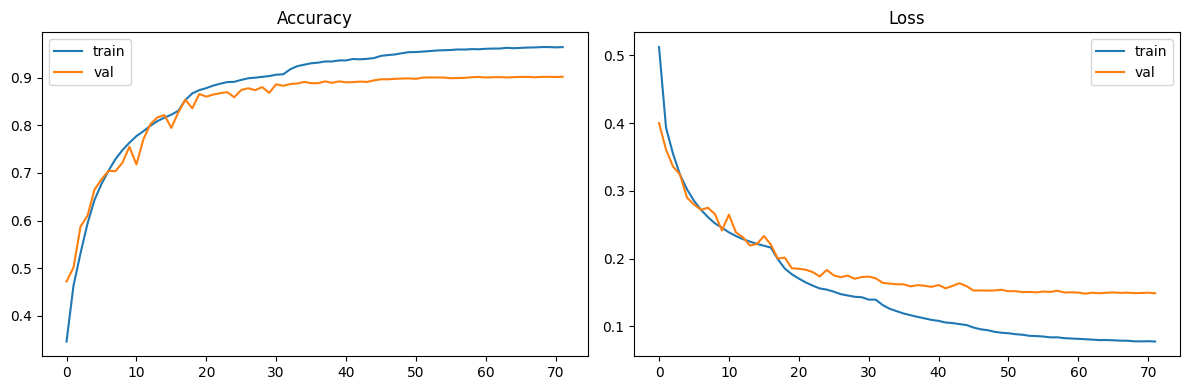

737/737 [==============================] - 32s 43ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      4712
           1       0.93      0.96      0.94      4711
           2       0.78      0.79      0.79      4711
           3       1.00      0.99      1.00      4712
           4       0.99      0.98      0.99      4711

    accuracy                           0.90     23557
   macro avg       0.90      0.90      0.90     23557
weighted avg       0.90      0.90      0.90     23557

[[3701  152  846    2   11]
 [  83 4503  125    0    0]
 [ 800  165 3732    3   11]
 [   1    1   16 4683   11]
 [  21   13   60   10 4607]]

🧠 Cohen Kappa Score: 0.8763


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpuqw41ha8\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpuqw41ha8\assets



⏱️ Total training time: 558.91 minutes


In [8]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Concatenate



tf.keras.backend.clear_session()

# ✅ Ensure GPU Usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# ⏱️ Start Timing
start_time = time.time()

# 📂 Load PPG Data
folder_path = r"D:\abhishek_extracted\plm"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_list, y_list = [], []
for file in mat_files:
    mat = scipy.io.loadmat(file)
    X_list.append(mat['ppg_signals'])
    y_list.append(mat['sleep_stages'].flatten())

X = np.vstack(X_list)
y = np.concatenate(y_list)

# ✅ Data Augmentation Functions
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

# 🔁 Class-wise Augmentation (focus on underrepresented)
np.random.seed(42)
augmented = []
target_distribution = np.bincount(y)
minority_classes = np.where(target_distribution < np.median(target_distribution))[0]

for signal, label in zip(X, y):
    if label in minority_classes:
        if np.random.rand() < 0.5:
            signal = jitter(signal)
        if np.random.rand() < 0.5:
            signal = magnitude_warp(signal)
        if np.random.rand() < 0.5:
            signal = scaling(signal.reshape(1, -1)).flatten()
    augmented.append(signal)

X = np.array(augmented)

# 🔄 Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 🧩 Handle Class Imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 🧠 Class Weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 🔁 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# 🔷 Preprocessing
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=5)

# ⚠️ Focal Loss Function
def focal_loss(gamma=1.5, alpha=[0.7, 0.5, 0.5, 0.3, 0.3]):
    alpha = tf.constant(alpha, dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        # Calculate cross-entropy
        ce = -y_true * tf.math.log(y_pred)
        
        # Pick alpha for each class (broadcasted)
        alpha_factor = y_true * alpha

        # Modulating factor
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)

        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))  # Sum across classes
    return loss_fn


# 🔹 MSR-SE Block: Multi-Scale Residual Squeeze-and-Excite
def MSR_SE_Block(x, filters):
    reg = tf.keras.regularizers.l2(1e-4)

    branch1 = SeparableConv1D(filters, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(filters, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(filters, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)

    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)

    excitation = Dense(filters, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)

    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)

    out = Add()([scaled, residual])
    return LayerNormalization()(out)


# 🔹 Frequency Fusion Block
def FrequencyFusionBlock(x, filters):
    reg = tf.keras.regularizers.l2(1e-4)

    # Low-frequency emphasis (smooth features)
    low = SeparableConv1D(filters, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)

    # High-frequency component
    high = x - AveragePooling1D(pool_size=3, strides=1, padding='same')(x)

    out = Add()([low, high])
    return LayerNormalization()(out)


def build_hybrid_cnn_rvfl(input_shape):
    reg = l2(1e-4)
    inputs = Input(shape=input_shape)
    x = GaussianNoise(0.05)(inputs)

    # First CNN Block
    x = SeparableConv1D(64, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)

    # 🔹 MSR-SE Block
    x = MSR_SE_Block(x, 64)

    # Second Conv Block + Residual
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)

    x = SeparableConv1D(64, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)

    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)

    # 🔹 Frequency Fusion Block
    x = FrequencyFusionBlock(x, 64)

    # Third Conv Block
    x = SeparableConv1D(128, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)

    res = SeparableConv1D(128, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)

    # Attention Mechanism
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(256, activation="relu", kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(128, activation="sigmoid", kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])

    # Residual Merge
    x = Add()([x, res])
    x = LayerNormalization()(x)

    # RVFL-like Dense Layers
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)

    outputs = Dense(5, activation='softmax')(x)
    return Model(inputs, outputs)

# ⚙️ Compile & Train
model = build_hybrid_cnn_rvfl((X_train.shape[1], 1))
model.compile(optimizer=Adam(1e-4), loss=focal_loss(gamma=1.5, alpha=[0.7, 0.5, 0.5, 0.3, 0.3]), metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat),
                    epochs=100, batch_size=64, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

# 📉 Training Curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Evaluation
y_pred = model.predict(X_test)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# 💾 Save for Deployment
model.save("cnn_rvfl_final_model.keras")

# ✅ Export for TFLite (Edge Devices)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_rvfl_model.tflite", "wb") as f:
    f.write(tflite_model)

# ⏱️ Total Training Time
end_time = time.time()
print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")


In [9]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")



✅ Overall Test Accuracy: 0.9010


In [12]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")



📈 Final Accuracy: Train = 0.9643, Val = 0.9020
📉 Final Loss: Train = 0.0774, Val = 0.1487


In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.9010185043529235
Weighted F1 Score: 0.9010179806695262
Macro Precision: 0.9011310860519867
Macro Recall: 0.9010494889863301


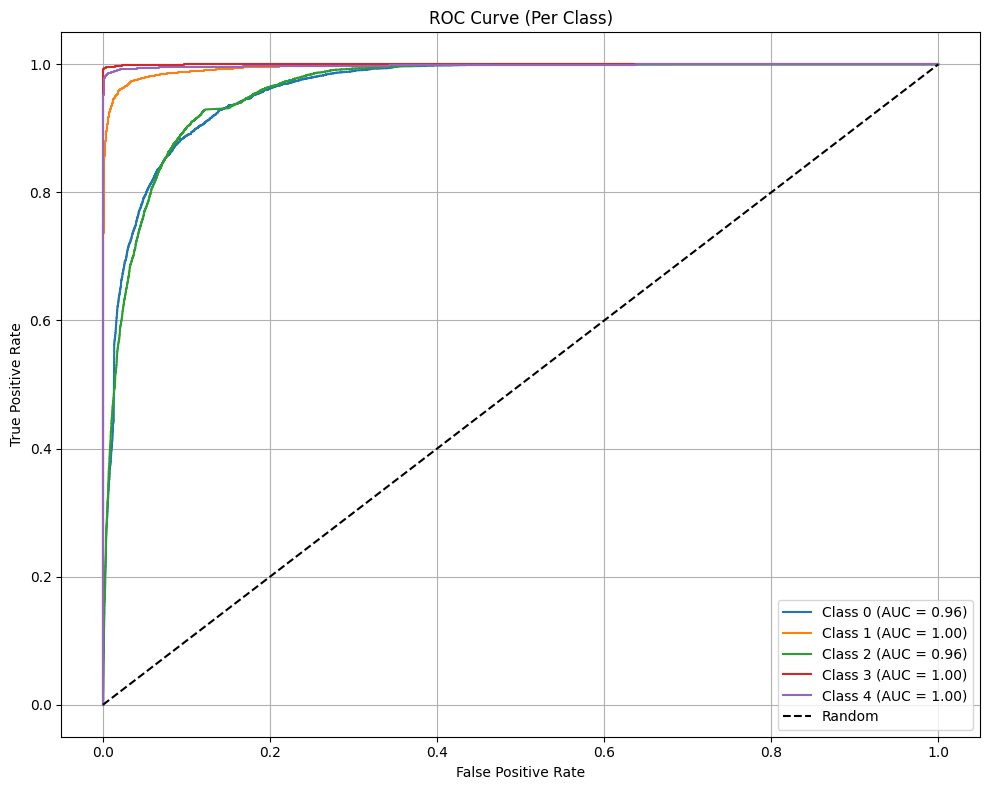

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 5
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
